# K-means Clustering

K-means clustering is a simple unsupervised algorithm that groups data into $k$ number of clusters by iteratively reassigning data to its closest centroid. 

The algorithm:
1. Initialise k cluster centroids from k randomly selected data points
    - Not necessary for inital centroids to be data points
    
    
2. Repeat if stopping criteria not reached:
    - Assign each data point a cluster based on the its closest centroid
    - Get the new centroid of the cluster using the mean of its data points
    
<br>

The stopping criteria can be any of the following:
1. Change between old and new centroids < threshold
2. Points belong to each cluster remains the same
3. Specified max iterations is reached

<br>

The goal of clustering is to reduce the sum of squared distances between each data point and its cluster centroid it was assigned to. This is also known as the **intracluster distance or inertia**. The larger the intracluster distance, the bigger the spread of clusters. Given that we want data points in each cluster to be as similar to each other, we want a smaller intracluster distance.

As the number of clusters increase, the inertia is expected to decrease, although this is not guaranteed. One method to choose the best k value is to perform k-means several times with different values of k and get the 'elbow' value. Note that the larger the number of clusters, the larger the computational cost. Additionally, a larger number of clusters may result in less meaningful clusters, since theoretically, inertia is 0 when each data point is a cluster.

Another method for evaluating clusters is the Dunn Index. The Dunn Index is the ratio of the smallest intercentroid distance(i.e the shortest distance between a centroid to another centroid) and the largest intracluster distance(i.e the largest distance between a data point and its centroid).

The Dunn Index is given by:

<br>

$$
\text{Dunn Index} = \frac{\text{min(Intercentroid Distance)}}{\text{max(Intracluster Distance)}}
$$

<br>

It is usually the case that a highest Dunn Index is favourable as it means that the clusters are as tightly packed and as far away from each other as possible, although the value may vary depending on the spread of the data observed.

## K-means ++

The initialization of centroids in vanilla K-means can affect the algorithm's ability to reach the global minimum. Poor initialization can result in bad clusters.

K-means++ is a smart method of intitializing centroids by maximising the distances between them. It replaces (1) in the vanilla algorithm above to get $k$ initial cluster centroids.

Intialization:

1. Randomly select a data point to be the first centroid


2. Compute the distance between that centroid and the rest of the data points


3. Select the next centroid from the data points such that the probability of choosing a point as centroid is directly proportional to its squared distance of its nearest centroid. The further a data point is to a centroid, the more likely it is to be the next centroid.


4. Repeat step 3 until k centroids are chosen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style = "darkgrid")

from sklearn import datasets
import math
import time

In [2]:
def get_distance(x1, x2, axis=None):
    distance = np.sum((x1 - x2)**2, axis=axis)
    return np.sqrt(distance)

In [3]:
def plot(X, y):
    plt.figure(figsize=(12,12))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], edgecolor='k',
                    s=80, linewidth=1)

    plt.xlim(X[:, 0].min()-1, X[:, 0].max()+1)
    plt.ylim(X[:, 1].min()-1, X[:, 1].max()+1)
    
    plt.show()

In [4]:
class K_means():
    def __init__(self, k=2, max_iterations=100):
        self.k = k
        self.max_iterations = max_iterations
        self.inertias = []
        self.dunns = []
        self.y_preds = []
        self.centroids_prog = []
        
    def init_centroids(self, X):
        n_samples, n_features = np.shape(X)
        # Randomly choose k centroids without replacement
        self.init_centroids_indices = np.random.choice(n_samples, self.k, replace=False)
        centroids = X[self.init_centroids_indices]
        
        return centroids
    
    
    def get_centroid(self, x, centroids):
        closest_centroid = 0
        closest_distance = math.inf
    
        # Pick closest centroid 
        for idx, centroid in enumerate(centroids):
            distance = get_distance(x, centroid)
            if distance < closest_distance:
                closest_distance = distance
                closest_centroid = idx     
                
        return closest_centroid
    
    
    def create_clusters(self, X, centroids):
        n_samples = np.shape(X)[0]
        clusters = [[] for _ in range(self.k)]
        for sample_i, sample in enumerate(X):
            centroid_i = self.get_centroid(sample, centroids)
            clusters[centroid_i].append(sample_i)
            
        return clusters
    
    
    def cal_new_centroids(self, X, clusters):
        n_features = np.shape(X)[1]
        centroids = np.zeros((self.k, n_features))
        for i, cluster in enumerate(clusters):
            centroid = np.mean(X[cluster], axis=0)
            centroids[i] = centroid
            
        return centroids
    
    
    def _get_cluster_labels(self, clusters, X):
        """ Classify samples as the index of their clusters """
        y_pred = np.zeros(np.shape(X)[0])
        for cluster_i, cluster in enumerate(clusters):
            for sample_i in cluster:
                y_pred[sample_i] = cluster_i
                
        return y_pred
    
    
    def fit(self, X):
        self.centroids = self.init_centroids(X)
        num_iterations = 0
        for i in range(self.max_iterations):
            self.clusters = self.create_clusters(X, self.centroids)
            self.y_preds.append(self._get_cluster_labels(self.clusters, X))
            prev_centroids = self.centroids
            self.centroids = self.cal_new_centroids(X, self.clusters)
            self.centroids_prog.append(self.centroids)
            inertia, dunn_index = self.get_metrics(X)
            self.inertias.append(inertia)
            self.dunns.append(dunn_index)
            
            diff = self.centroids - prev_centroids
            print(f'Iteration: {i}, Inertia: {inertia:.2f}, Dunn Index: {dunn_index:.4f}')
            if not diff.any():
                break
            num_iterations += 1
            
        self.plot_metrics(num_iterations)
        return self._get_cluster_labels(self.clusters, X)   
    

    def get_inertia(self, X):
        inertia = 0
        for cluster_i, cluster in enumerate(self.clusters):
            # Get the centroid for cluster
            cluster_centroid = self.centroids[cluster_i]
            # Get the coordinates of data in cluster
            cluster_coordinates = X[clf.clusters[cluster_i]]
            # Sum of squared distances between cluster points and centroid
            inertia += np.sum((np.array(cluster_coordinates) - cluster_centroid)**2)    
            
        return inertia
    
    
    def get_metrics(self, X):
        inertia = 0
        max_intracluster_dist = 0
        intercentroid_dist = np.zeros((self.k, self.k))
        for cluster_i, cluster in enumerate(self.clusters):
            # Get the centroid for cluster
            cluster_centroid = self.centroids[cluster_i]
            # Get the coordinates of data in cluster
            cluster_coordinates = X[clf.clusters[cluster_i]]
            # Get distance between cluster points and centroid
            dist = np.array(cluster_coordinates) - cluster_centroid
            # Sum of squared distances between cluster points and centroid
            inertia += np.sum(dist**2)
            # Get maximum intracluster distance for cluster
            max_cluster_intra_dist = max(np.sum(dist**2, axis=1))
            if max_cluster_intra_dist > max_intracluster_dist:
                max_intracluster_dist = max_cluster_intra_dist.copy()
        
        # Adjacency Matrix for centroid distances
        for i in range(self.k):
            for j in range(i+1, self.k):
                intercluster_distance = get_distance(self.centroids[i], self.centroids[j]) 
                intercentroid_dist[i][j] = intercluster_distance
                intercentroid_dist[j][i] = intercluster_distance
        
        dunn_index = np.min(intercentroid_dist[np.nonzero(intercentroid_dist)]) / max_cluster_intra_dist
        return inertia, dunn_index
        
    
    def plot_clusters(self, X, y_pred=None, centroids_prog=None, **kwargs):
        plt.figure(figsize=(12,12))
        if kwargs['init']:
            centroids = X[self.init_centroids_indices]
        else:
            centroids = self.centroids
        
        sns.scatterplot(x=X[:, 0], y=X[:, 1], edgecolor='k', hue=y_pred,
                        s=80, linewidth=1, palette='pastel')
        sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1],
                        marker='x', s=100, linewidth=3, color='red', label='centroid')

        plt.xlim(X[:, 0].min()-2, X[:, 0].max()+2)
        plt.ylim(X[:, 1].min()-2, X[:, 1].max()+2)
        plt.title('{}, k={}'.format(kwargs['title'], self.k), fontsize=15)
            
        plt.legend(fontsize=12, loc='best', shadow=True)
        plt.show()
        
        
    def plot_metrics(self, iterations):
        fig, ax1 = plt.subplots(figsize=(10,6))
        l1 = ax1.plot(np.arange(iterations+1), self.inertias, lw=3, 
                      label='Inertia', color='g')
        ax1.set_ylabel('Inertia')
        ax1.set_xlabel('Iterations')
        
        ax2 = ax1.twinx()
        l2 = ax2.plot(np.arange(iterations+1), self.dunns, lw=3, 
                      label='Dunn Index', color='r')
        ax2.set_ylabel('Dunn Index', rotation=-90, labelpad=15)
        
        # Make both ticks and gridlines align
        ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 10))
        ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 10))
        
        # Combine legends to one
        ln = l1+l2
        labs = [l.get_label() for l in ln]
        plt.legend(ln, labs, loc='best', shadow=True)
        
        plt.title('Metrics', fontsize=20)
        plt.show()

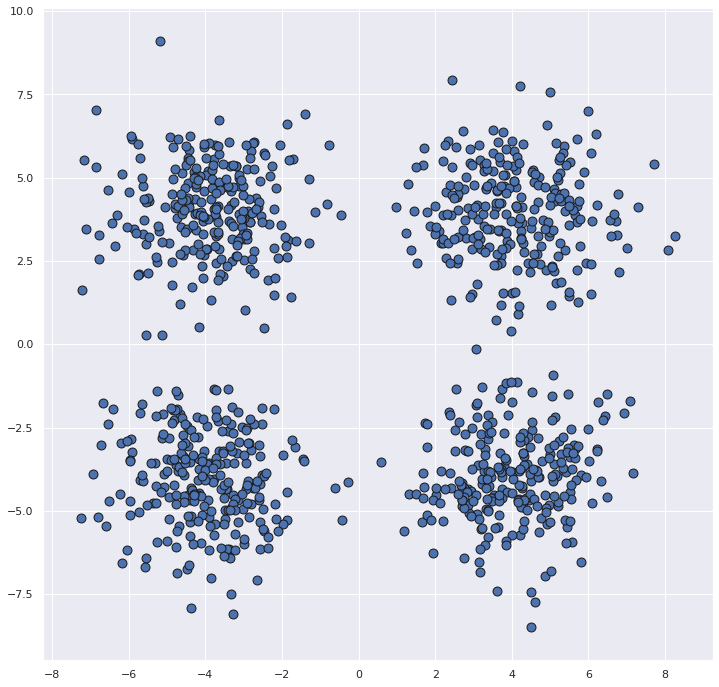

In [5]:
centers = [(-4, -4), (-4, 4), (4, -4), (4, 4)]
n_clusters = len(centers)
X, y = datasets.make_blobs(n_samples=1000, centers=centers, cluster_std=1.3)
plot(X, y)

Elapsed time: 0.101 ms
Iteration: 0, Inertia: 16043.97, Dunn Index: 0.0335
Iteration: 1, Inertia: 10672.01, Dunn Index: 0.0969
Iteration: 2, Inertia: 8773.82, Dunn Index: 0.1380
Iteration: 3, Inertia: 4808.33, Dunn Index: 0.1770
Iteration: 4, Inertia: 3438.55, Dunn Index: 0.3786
Iteration: 5, Inertia: 3428.49, Dunn Index: 0.4708
Iteration: 6, Inertia: 3428.49, Dunn Index: 0.4708


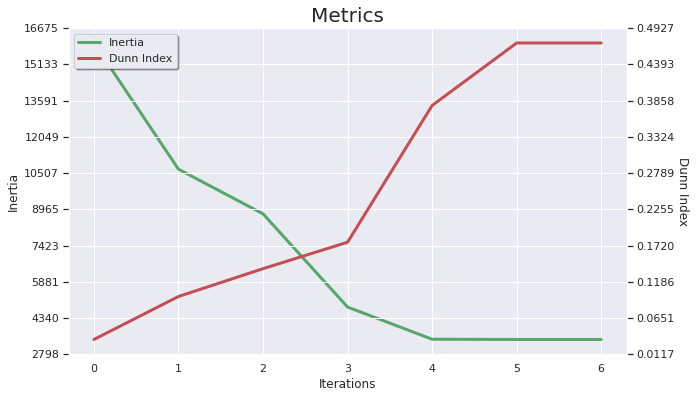

In [6]:
start = time.process_time()
clf = K_means(k=n_clusters)
print(f'Elapsed time: {(time.process_time() - start)*1e3:.3} ms')
y_pred = clf.fit(X)

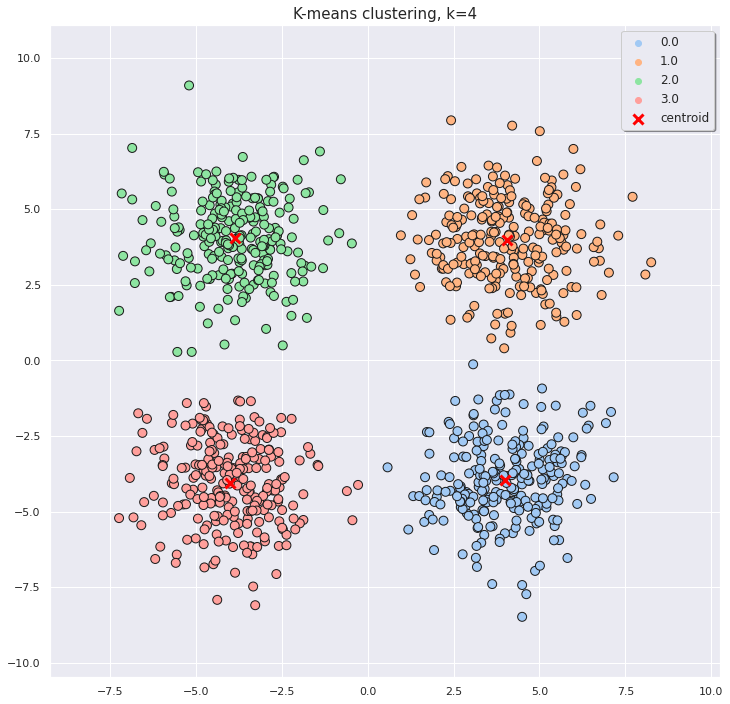

In [7]:
clf.plot_clusters(X, y_pred, init=False, title='K-means clustering')

We can make K-means++ as a subclass of vanilla K-means and redefine how we initialize centroids.

In [8]:
class K_means_pp(K_means):
    def init_centroids(self, X):
        n_samples, n_features = np.shape(X)
        # Pick first centroid
        self.init_centroids_indices = np.random.choice(n_samples)
        centroids = np.expand_dims(X[self.init_centroids_indices], axis=0)
    
        for i in range(1, self.k):
            # Get unchosen data indices 
            # using np.setdiff1d which finds difference between 2 arrays
            unchosen_X_indices = np.setdiff1d(np.arange(n_samples), self.init_centroids_indices)
            unchosen_X = X[unchosen_X_indices]

            probs = []
            for sample_i, sample in enumerate(X[unchosen_X_indices]):
                closest_distance_squared = get_closest_squared(sample, centroids)
                probs.append(closest_distance_squared)
                
            #Probability list
            probs = probs / sum(probs)
            # Choose next index tagged with probabilities
            # Indices with larger probabilities is more likely to be chosen
            next_centroid_index = np.random.choice(unchosen_X_indices, p=probs)
            next_centroid = np.expand_dims(unchosen_X[next_centroid_index], axis=0)

            self.init_centroids_indices = np.append(self.init_centroids_indices, next_centroid_index)
            centroids = np.append(centroids, next_centroid, axis=0)
        
        return centroids
    
    
def get_closest_squared(x, centroids):
    closest_distance = math.inf
    # Pick closest centroid 
    for idx, centroid in enumerate(centroids):
        distance = get_distance(x, centroid)
        if distance < closest_distance:
            closest_distance = distance

    return closest_distance**2

Elapsed time: 0.0677 ms
Iteration: 0, Inertia: 33756.42, Dunn Index: 0.4171
Iteration: 1, Inertia: 34751.45, Dunn Index: 0.4672
Iteration: 2, Inertia: 34835.15, Dunn Index: 0.4708
Iteration: 3, Inertia: 34835.15, Dunn Index: 0.4708


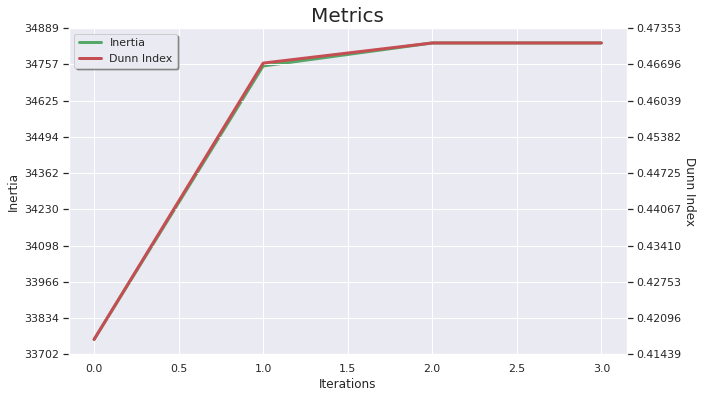

In [9]:
start = time.process_time()
clf_pp = K_means_pp(k=n_clusters)
print(f'Elapsed time: {(time.process_time() - start)*1e3:.3} ms')
y_pred = clf_pp.fit(X)

Note that the elapsed time for K-means++ is smaller than that for vanilla K-means. This is because K-means++ runs in $O(logn)$ while vanilla K-means runs in $O(n^2)$. Actual times may vary due to random initialization of vanilla K-means, and implementation shown here may not be the most computationally efficient. But almost always K-means++ runs faster than vanilla K-means.

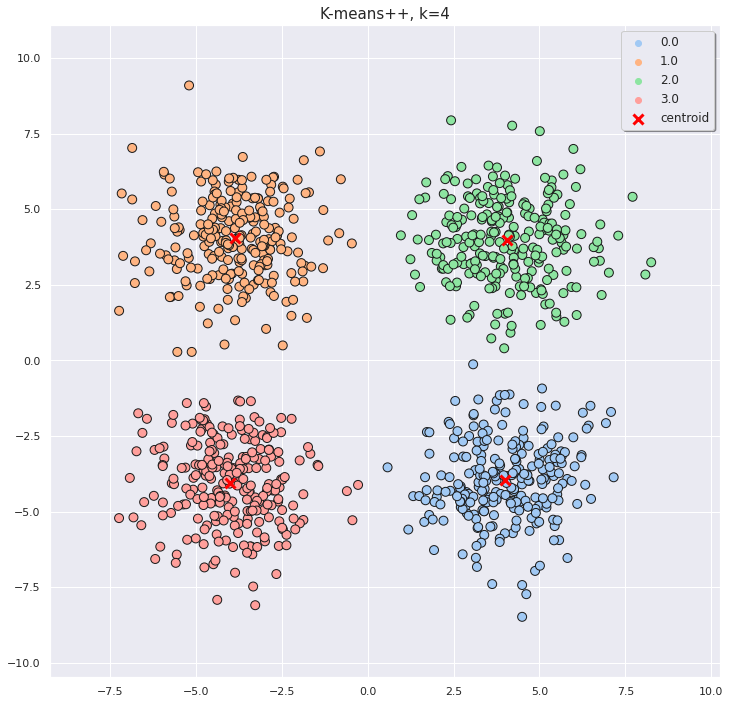

In [10]:
clf_pp.plot_clusters(X, y_pred, init=False, title='K-means++')

### Intializations of K-means vs K-means++

Note that K-means++ initalization is usually better than that for K-means. However because we are assigning probabilities to each data point to be chosen as the next centroid and not just choosing the furthest data point, initial centroids are not guaranteed to be as sparse as possible.

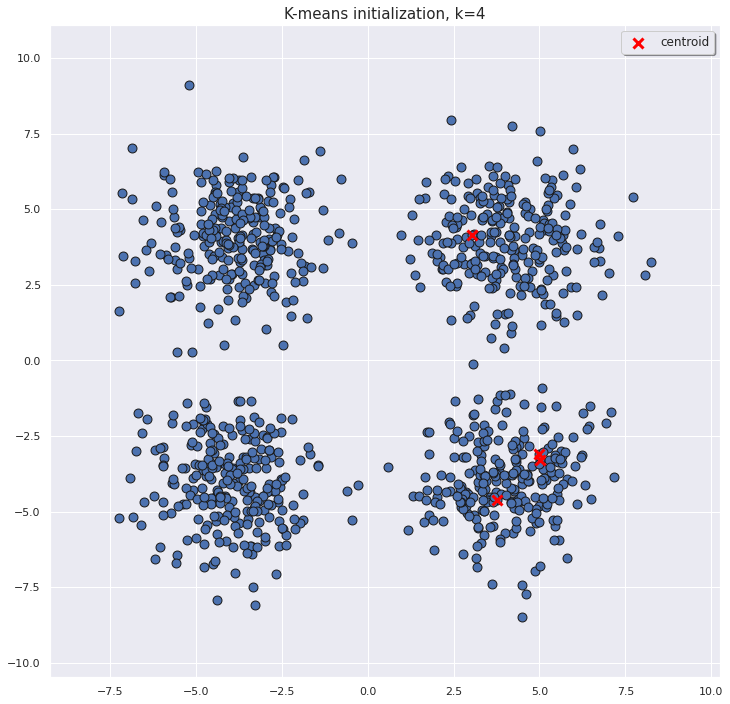

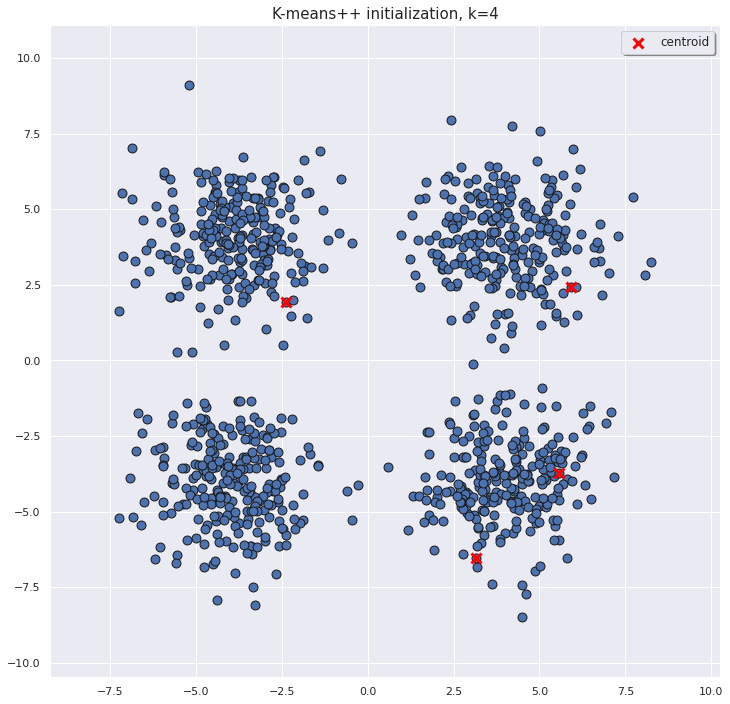

In [11]:
clf.plot_clusters(X, init=True, title='K-means initialization')
clf_pp.plot_clusters(X, init=True, title='K-means++ initialization')

### References
[1] Andrew Ng. The k-means clustering algorithm.CS229 Spring 2020 Notes. http://cs229.stanford.edu/notes2020spring/cs229-notes7a.pdf

[2] Arthur, D., & Vassilvitskii, S. (n.d.). k-means++: The Advantages of Careful Seeding. 11. http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf